In [1]:
# change directory to where the repo was locally saved on your machine
import os
os.chdir("C:/Users/braun/OneDrive/Desktop/NL2EN")

# Data Preprocessing #

In [2]:
# First, let's read sentences pairs into memory and inspect

import pandas as pd

df = pd.read_csv("sentences.tsv", sep='\t', usecols=[1,3], names=["en", "nl"])

In [3]:
print(df.shape)
df.head()

(147838, 2)


,en,nl
0,Let's try something.,Laten we iets proberen!
1,Let's try something.,Laat ons iets proberen.
2,I have to go to sleep.,Ik moet gaan slapen.
3,Today is June 18th and it is Muiriel's birthday!,Vandaag is het 18 juni en het is de verjaardag...
4,Muiriel is 20 now.,Muiriel is nu 20 jaar oud.


mean      30.300877
median    27.000000
Name: en, dtype: float64


<Axes: ylabel='Frequency'>

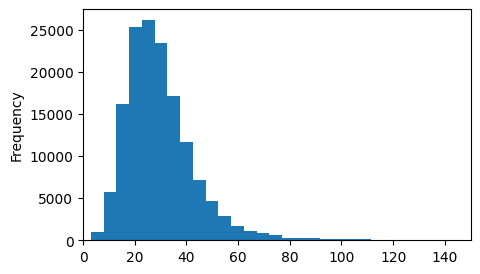

In [4]:
# most sentences are pretty short (~30 characters); model capability will reflect this.

print(df.en.apply(len).aggregate(["mean", "median"]))
df.en.apply(len).plot.hist(bins=300, xlim=(0,150), figsize=(5,3))

In [5]:
# perform cleanup:
# 1) remove null rows
# 2) remove sentences with non-NL/EN characters
# 3) replace escape characters with blank ""
# 4) strip sentences of any whitespaces
# 5) add BOS_TOKEN <s> and EOS_TOKEN </s> to each sentence (for training prep)
# net result: ~5K rows (~3%) of dataset is ignored

import sentence_prep

data = sentence_prep.initial_cleanup(df)

In [6]:
print(data.shape)
data.head()

(142776, 2)


,en,nl
0,<s>Let's try something.</s>,<s>Laten we iets proberen!</s>
1,<s>Let's try something.</s>,<s>Laat ons iets proberen.</s>
2,<s>I have to go to sleep.</s>,<s>Ik moet gaan slapen.</s>
3,<s>Today is June 18th and it is Muiriel's birt...,<s>Vandaag is het 18 juni en het is de verjaar...
4,<s>Muiriel is 20 now.</s>,<s>Muiriel is nu 20 jaar oud.</s>


# Tokenization #

In [7]:
# we now train a tokenizer specifically for our dataset (vs. using a pre-trained)
# the tokenization process will follow Byte-Pair-Encoding (BPE) in which words are broken into subwords based upon occurence
# more details here: https://en.wikipedia.org/wiki/Byte_pair_encoding

# note: you can change tokenizer and training settings in config.py
# in this case, we want the tokenizer to produce a vocab of 30k tokens
import tokenizer_prep

tokenizer = tokenizer_prep.train_tokenizer(data)

tokenizer training complete


In [8]:
# the tokenizer has now generated a 30K vocab for us (plus special tokens), which we can inspect.
# each subword/token is a key, and the arbitrary token id is the value

vocab = tokenizer.get_vocab()

print("a few tokens from the vocab:")
print(dict(sorted(vocab.items(), key = lambda x: x[1], reverse = True)[:10]))
print("\nspecial tokens are inserted into the vocab first and thus have a small token id:")
print(dict(sorted(vocab.items(), key = lambda x: x[1], reverse = False)[:10]))

a few tokens from the vocab:
{'Ġeenyġ': 30003, 'Ġpassionateġ': 30002, 'Ġpassendeġ': 30001, 'Ġbijgedragenġ': 30000, 'Ġbijvoe': 29999, 'Ġbijgekomenġ': 29998, 'Ġbijzi': 29997, 'Ġbijeenġ': 29996, 'Ġterugwegġ': 29995, 'Ġverzekerġ': 29994}

special tokens are inserted into the vocab first and thus have a small token id:
{'<s>': 0, '</s>': 1, '[PAD]': 2, '[UNK]': 3, '!': 4, '$': 5, '%': 6, "'": 7, ',': 8, '-': 9}


In [9]:
# With a trained tokenizer, we can tokenize a sentence.  We include the BOS/EOS tokens for proper tokenization
# note the tokenizer includes a right PAD (special token) up to the model's pre-determined sequence limit

e = tokenizer.encode("<s>The dog is black.</s>")

print("tokens:\n",e.tokens)
print("\ntoken_ds:\n",e.ids)

tokens:
 ['<s>', 'ĠTheġ', 'Ġdogġ', 'Ġisġ', 'Ġblackġ', '.ġ', '</s>', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

token_ds:
 [0, 4965, 1387, 305, 2969, 233, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [10]:
# we encode all of the sentences from our dataset.
# this produces a list of Encoding objects, which contain the sequence token and ids

nl_encoded = tokenizer.encode_batch(data.nl.values)
en_encoded = tokenizer.encode_batch(data.en.values)

In [11]:
print(nl_encoded[0], "\n")
print(nl_encoded[0].tokens, "\n")
print(nl_encoded[0].ids, "\n")

Encoding(num_tokens=30, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]) 

['<s>', 'ĠLatenġ', 'Ġweġ', 'Ġietsġ', 'Ġproberenġ', '!ġ', '</s>', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'] 

[0, 13518, 519, 947, 2806, 262, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] 



In [12]:
# to assist with training, we'll group the encoded sentences by equal-length
# this produces a list of tuples with structure:
# [
#     (seq01, seq02),
#     (seq11, seq12),
#     (seq21, seq22),
#     ...
# ]
import config

ignore_token_ids = [tokenizer.token_to_id(x) for x in config.SPECIAL_TOKENS.values()]
grouped_data = tokenizer_prep.group_sentences(nl_encoded, en_encoded, ignore_token_ids)

<Axes: title={'center': 'Sorted Dataset by Sentence Length'}, xlabel='# of Samples', ylabel='Length of Sequence'>

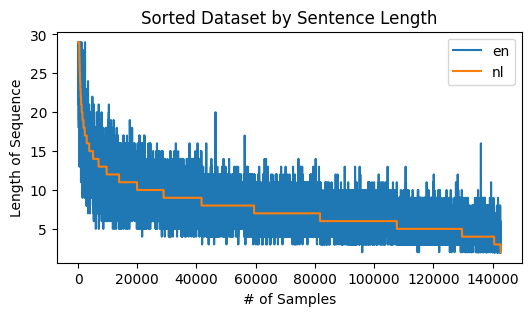

In [13]:
# we can visualize the groups to ensure proper grouping
# we will feed the data (sorted in this order) into the model, thus no shuffling for training
import tokenizer_prep

# Note: grouping was performed on NL sentences,
# so EN groupings are not as clean but do mimic a similar trend
tmp = pd.DataFrame.from_records(grouped_data, columns=["nl", "en"])
tmp[["en","nl"]].applymap(lambda x: tokenizer_prep.sequence_length(x, ignore_token_ids)).plot(
    title="Sorted Dataset by Sentence Length",
    xlabel="# of Samples",
    ylabel="Length of Sequence",
    figsize=(6,3),
)

# Model Training Data Setup #

In [14]:
# Encoder/Decoder Transformers have two inputs, X1 (encoder) and X2 (decoder)
# X1 is the sentence to be translated (NL is our case) and
# X2 is the EN sentences to be translated into.

# output (y) will be a +1 shifted version of X2 (i.e. next token) where y(t) = X2(t-1)

# For training, we provide the entire length of X1, X2, and y to the model and 
# perform masking to retain the auto-regressive property of Transformers
import numpy as np

X1 = np.array([x[0] for x in grouped_data]).reshape(len(grouped_data), config.T)
X2 = np.array([x[1] for x in grouped_data]).reshape(len(grouped_data), config.T)

pad_token_id = tokenizer.token_to_id(config.SPECIAL_TOKENS["PAD_TOKEN"])
y = np.array([x[1][1:] + [pad_token_id] for x in grouped_data])

In [15]:
# we can see that y is the shifted version of X2:
print("X2 sample:\n", X2[0,:])
print("\ny sample:\n", y[0,:])

X2 sample:
 [    0   690   296   522   513   967   360   488  4797  1748   267   414
  1074  7526   669   717  1010   513  2623   267  4481   455  2278   467
   338  4797  7987   331 14008   233]

y sample:
 [  690   296   522   513   967   360   488  4797  1748   267   414  1074
  7526   669   717  1010   513  2623   267  4481   455  2278   467   338
  4797  7987   331 14008   233     2]


In [51]:
# now we split our data into train/test and pass each to pytorch's `Dataset` class to enable seemless functionality during training
# see dataset.py for notes on the Dataset setup

import dataset
importlib.reload(dataset)
from sklearn.model_selection import train_test_split

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(
    X1,
    X2,
    y,
    test_size=0.15, # change as desired
    shuffle=False, # already shuffled and grouped
)

train_data = dataset.LanguageDataset(X1_train, X2_train, y_train, pad_token_id=pad_token_id)
test_data = dataset.LanguageDataset(X1_test, X2_test, y_test, pad_token_id=pad_token_id)

In [52]:
# we'll also setup DataLoaders which will serve our Transformer data during training
# I have setup 1 loader for training, and two additional loaders for evaluation of 
# a larger portion of the train/test dataset (performed periodically throughout training)
from torch.utils.data import DataLoader


training_dl = DataLoader(
    train_data,
    batch_size=config.BATCH_SIZE,
    shuffle=False,  # keep sequences of the same length together
    drop_last=False,
)

# for loss performance over train/test datasets (vs. batch being trained on)
train_dl = DataLoader(
    train_data,
    batch_size=config.BATCH_SIZE_VAL,
    shuffle=True,   # sample across the dataset, regardless of sequence len
    drop_last=False,
)

test_dl = DataLoader(
    test_data,
    batch_size=config.BATCH_SIZE_VAL,
    shuffle=True,
    drop_last=False,
)

In [53]:
# the training dataloader will pass the model a number of sequences (of batch size)
# each batch setup will be as follows

training_dl_iter = iter(training_dl)
x1, x2, y_batch, x1padmask = next(training_dl_iter)

print("X1 sample:\n", x1[0])
print("\nX2 sample:\n", x2[0])
print("\ny sample:\n", y_batch[0])
print("\nX1 padding sample:\n", x1padmask[0])

X1 sample:
 tensor([    0, 23692,  1542,   351,   357,   353,  4806,   305,   267,  5895,
          403,   477,   363,   353,   831,  1716,  2618,    90,  1150,   267,
         6592,   344, 12443,   665,   551, 16179,   233, 21831,   387,   519],
       dtype=torch.int32)

X2 sample:
 tensor([    0,   690,   296,   522,   513,   967,   360,   488,  4797,  1748,
          267,   414,  1074,  7526,   669,   717,  1010,   513,  2623,   267,
         4481,   455,  2278,   467,   338,  4797,  7987,   331, 14008,   233],
       dtype=torch.int32)

y sample:
 tensor([  690,   296,   522,   513,   967,   360,   488,  4797,  1748,   267,
          414,  1074,  7526,   669,   717,  1010,   513,  2623,   267,  4481,
          455,  2278,   467,   338,  4797,  7987,   331, 14008,   233,     2])

X1 padding sample:
 tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, Fals

# Model Architecture #

This example closely follows the model architecture of the paper "Attention is All You Need".

I have created a detailed visual of the model architecture here:
 https://docs.google.com/presentation/d/1sRWV0hxIgL8ZNyrqV_jz7vX5l815RJI5l_KlXoVJHAQ/edit#slide=id.g29d8fe39d9a_0_

See the model.py file for model specifics.  I have annotated throughout, and have included tensor sizes at relevant steps.  Each class
object relates to an item within the architecture visual at the above link.

Note, for convenience, I have included the inference (generate) function within the model object itself.
Therefore, we also need to pass the tokenizer to the model (even though the tokenizer is not involed during training, just
during inference for encoding/decode input/output)

In [54]:
# model is initialized using params located in config.py

import model
model = model.LanguageModel(tokenizer).to(config.DEVICE)

# model weights are random, so output is nonsensical at this point
s = "De lucht is blauw."  # "The sky is blue."
print(model.generate(s))

auto scho auto fooicod within rapid abandon repeat announced paraff soort link scho biologisch USA Spot Prices bet confir afsluiten vermakelijk vijfhonderdav gevestH mirsber kill Read


# Training #

In [55]:
# for training, we need five things:

# 1) data, connected to data loaders - ✅
# 2) a model object - ✅
# 3) a loss function - TODO
# 4) an optimizer - TODO
# 5) learning schedule - TODO

# for #3, we'll use pytorch's CrossEntropyLoss() given this is a multiclass problem (each token in the vocab is a 'class').
# Note this loss function does NOT require softmax (probability) output from the model and expects raw 'logits'.

# for #4, we'll use AdamW
# for #5, we'll use a "one cycle" learning rate schedule.  This involves a quick "warm up" period
# followed by a decaying learning rate over time (see below graph).
# I recommend reviewing the different learning schedule options. see here for example visuals on each scheduler: 
# https://medium.com/towards-data-science/a-visual-guide-to-learning-rate-schedulers-in-pytorch-24bbb262c863

In [124]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn as nn

# note: you can change training settings in config.py

import importlib
importlib.reload(config)

steps_per_epoch = int(train_data.__len__() / training_dl.batch_size)

# 3) loss function
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_token_id, label_smoothing=0.1)  # don't compute loss for pad tokens

# 4) optimizer
optimizer = AdamW(
    model.parameters(),
    lr=config.INITIAL_LR,
    betas=(0.9, 0.999),
    weight_decay=1e-2,
)

# 5) learning schedule
scheduler = OneCycleLR(
    optimizer,
    max_lr=config.MAX_LR,
    epochs=config.EPOCHS,
    steps_per_epoch=steps_per_epoch,
    pct_start=config.WARMUP_STEPS / (config.EPOCHS *  steps_per_epoch),
    anneal_strategy="cos",
    cycle_momentum=True,
    base_momentum=0.7,
    max_momentum=.99,  # results in ZeroDivisionError if 1.0
    div_factor=config.MAX_LR / config.INITIAL_LR,
    final_div_factor=config.INITIAL_LR / config.FINAL_LR,
)

C:\Users\braun\anaconda3\envs\NL2EN\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


<Axes: title={'center': 'Learning Rate Schedule (All Epochs Combined)'}, xlabel='training step', ylabel='learning rate'>

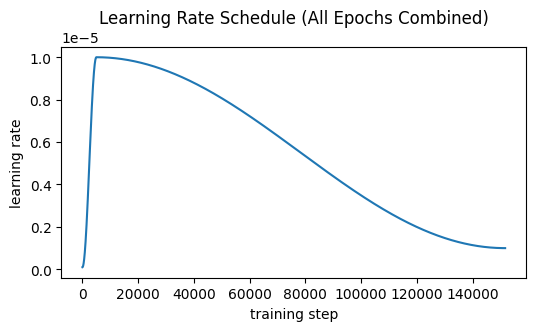

In [123]:
# in this case, well have epochs=10, with an initial learning rate of 1e-7, 5000 steps of warmup,
# a max learning rate of 1e-5, and then a long decay to 1e-6 learning rate.  See graph below for visualization of this.
# note: must reinitialize scheduler if executing this block
l = []
for _ in range(config.EPOCHS * steps_per_epoch):
    l.append(scheduler.get_last_lr()[0])
    scheduler.step()

pd.Series(l).plot(title="Learning Rate Schedule (All Epochs Combined)", figsize=(6,3), ylabel="learning rate", xlabel="training step")

In [57]:
# we completed all required steps, so training may commence:

# 1) data, connected to data loaders - ✅
# 2) a model object - ✅
# 3) a loss function - ✅
# 4) an optimizer - ✅
# 5) learning schedule - ✅

In [ ]:
# training loop which prints out loss updates X number of times within each epoch (see config.PRINT_TIMES_PER_EPOCH)

import time


import importlib
importlib.reload(config)


val_loss = []
bpe = train_data.__len__() // config.BATCH_SIZE
train_iter = iter(train_dl)  # for eval of loss over training set
test_iter = iter(test_dl)    # for eval of loss over testing set

print(f"Training with: epochs: {config.EPOCHS} | batch size: {config.BATCH_SIZE} | batches-per-epoch: {bpe}")

for e in range(config.EPOCHS):
    times = [time.time()]
    for batch_id, (x1_train_batch, x2_train_batch, y_train_batch, x1padmask_batch) in enumerate(training_dl):
        model.train()
        logits = model(x1_train_batch, x2_train_batch, x1padmask_batch)
        b, t, v = logits.shape  # needed for last batch in epoch that may not be of BATCH_SIZE
        logits = logits.view(b * t, v)  # reshape for loss calc
        y_train_batch = y_train_batch.view(b * t)  # reshape for loss calc
        training_loss = loss_fn(logits, y_train_batch)

        optimizer.zero_grad()
        training_loss.backward()
        optimizer.step()
        scheduler.step()

        # print training updates as desired frequency
        if batch_id % (bpe // config.PRINT_TIMES_PER_EPOCH) == 0:
            train_iter = iter(train_dl)
            x1_train, x2_train, y_train, x1padmask_train = next(train_iter)
            logits = model(x1_train, x2_train, x1padmask_train)
            logits = logits.view(config.BATCH_SIZE_EVAL * config.T, len(vocab))
            y_train = y_train.view(config.BATCH_SIZE_EVAL * config.T)
            train_loss = loss_fn(logits, y_train)

            test_iter = iter(test_dl)
            x1_test, x2_test, y_test, x1padmask_test = next(test_iter)
            logits = model(x1_test, x2_test, x1padmask_test)
            logits = logits.view(config.BATCH_SIZE_EVAL * config.T, len(vocab))
            y_test = y_test.view(config.BATCH_SIZE_EVAL * config.T)
            test_loss = loss_fn(logits, y_test)

            if config.SAVE_PATH_MODEL_OBJ is not None:
                # given a small model size, it's a good idea to save frequently in the event training timesouts (which
                # is often the case on free services like google colab).  If this occurs, simply reload the model
                # and start the training again.  Annoying but at least you're not starting from an untrained model.
                torch.save(model, config.SAVE_PATH_MODEL_OBJ)

            lr = scheduler.get_last_lr()[0]
            t = time.time() - times[-1]
            times.append(time.time())

            print(f"epoch: {e+1}  |  batch_id: {batch_id}  |  train loss: {train_loss:.7f}  |  test loss: {test_loss:.7f}  |  lr: {lr:.3e}  |  runtime: {t//60//60 % 60:.0f}h {t//60 % 60:.0f}m {t % 60:.0f}s")

In [130]:
# during training, output will look as follows (example output from my training).  Truncated to 5 epochs of output


Training with: epochs: 15 | batch size: 8 | batches-per-epoch: 15169
epoch: 1  |  batch_id: 0  |  train loss: 10.5764971  |  test loss: 10.6315508  |  lr: 1.000e-07  |  runtime: 0h 0m 16s
epoch: 1  |  batch_id: 303  |  train loss: 10.0541048  |  test loss: 10.0407505  |  lr: 2.195e-06  |  runtime: 0h 0m 51s
epoch: 1  |  batch_id: 606  |  train loss: 7.1837711  |  test loss: 6.7496824  |  lr: 6.692e-06  |  runtime: 0h 0m 51s
epoch: 1  |  batch_id: 909  |  train loss: 6.2527561  |  test loss: 6.4409866  |  lr: 9.807e-06  |  runtime: 0h 0m 51s
epoch: 1  |  batch_id: 1212  |  train loss: 6.3624659  |  test loss: 6.0754085  |  lr: 1.000e-05  |  runtime: 0h 0m 51s
epoch: 1  |  batch_id: 1515  |  train loss: 6.2190537  |  test loss: 5.8767591  |  lr: 9.999e-06  |  runtime: 0h 0m 50s
epoch: 1  |  batch_id: 1818  |  train loss: 6.0730982  |  test loss: 5.6175365  |  lr: 9.997e-06  |  runtime: 0h 0m 49s
epoch: 1  |  batch_id: 2121  |  train loss: 6.0330892  |  test loss: 6.2303038  |  lr: 9.995

# Inference #

Now that the model has been training, we can use it for NL -> EN translation
An important caveat:

This model is training on ~140K NL<>EN sentence pairs, whereas leading LLMs (e.g. Llama 2)
are trained on ~2 trillion token, so set your expectations accordingly :).  The primary purpose
of this project is to provide a clear walkthrough of the basic Encoder/Decoder model layout.

In [153]:
# TODO
# import torch
# from model import *
# M = torch.load("C:/Users/braun/OneDrive/Desktop/NL2EN_pytorch_model", map_location=config.DEVICE)

In [ ]:
# s = "Hallo."  # Hello.
# s = "De lucht is blauw."  # the sky is blue.
# s = "Hij loopt in het park."  # he walks in the park.
# s = "Wat is het grappigste dat je ooit hebt gedaan?"  # What's the funniest thing you've ever done?
# s = "Ik heb gisteren mijn moeder gebeld en ben toen boodschappen gaan doen."  # I made a call to my mother yesterday, and then I went grocery shopping.
model.generate(s, max_len=30, greedy=True)